In [26]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy as sp
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, PolynomialFeatures
from sklearn import datasets, linear_model, metrics
from sklearn.model_selection import train_test_split 
import descartes
import geopandas
from shapely.geometry import Point, Polygon

In [348]:
#load all data needed
col_names =["INSTNM", "MD_EARN_WNE_P10", "AVGFACSAL", "COSTT4_A", "ADM_RATE", "SAT_AVG", "STABBR", "DEBT_MDN", "UGDS"]


all_data_df = pd.read_csv('Extracted_Data.csv',
                 usecols=col_names)
all_data_df["AVGFACSAL"] = all_data_df["AVGFACSAL"] * 12 #make faculty salary yearly from monthly
all_data_df["ADM_RATE"] = all_data_df["ADM_RATE"] * 100 #make admission rate into a percent

#process bad data
nan_value = float("NaN")
all_data_df.replace("PrivacySuppressed", nan_value, inplace=True)
all_data_df.dropna(inplace=True)

#view data
all_data_df

,INSTNM,STABBR,COSTT4_A,AVGFACSAL,MD_EARN_WNE_P10,ADM_RATE,SAT_AVG,DEBT_MDN,UGDS
0,Alabama A & M University,AL,18888.0,84948.0,29900,89.89,823.0,12430.5,4051.0
1,University of Alabama at Birmingham,AL,19990.0,122040.0,40200,86.73,1146.0,12500,11200.0
3,University of Alabama in Huntsville,AL,20306.0,112092.0,45600,80.62,1180.0,13000,5525.0
4,Alabama State University,AL,17400.0,78684.0,26700,51.25,830.0,11000,5354.0
5,The University of Alabama,AL,26717.0,115260.0,42700,56.55,1171.0,14909,28692.0
...,...,...,...,...,...,...,...,...,...
6552,University of Minnesota-Rochester,MN,22141.0,69456.0,49800,54.21,1149.0,16500,477.0
7246,Pennsylvania State University-World Campus,PA,25441.0,52068.0,48500,71.38,968.0,19000,4881.0
7386,Augusta University,GA,7715.0,95256.0,58500,41.03,1002.0,6000,5456.0
7434,University of North Georgia,GA,16525.0,65904.0,40600,61.02,1009.0,5985,14502.0


/Users/taimur/opt/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



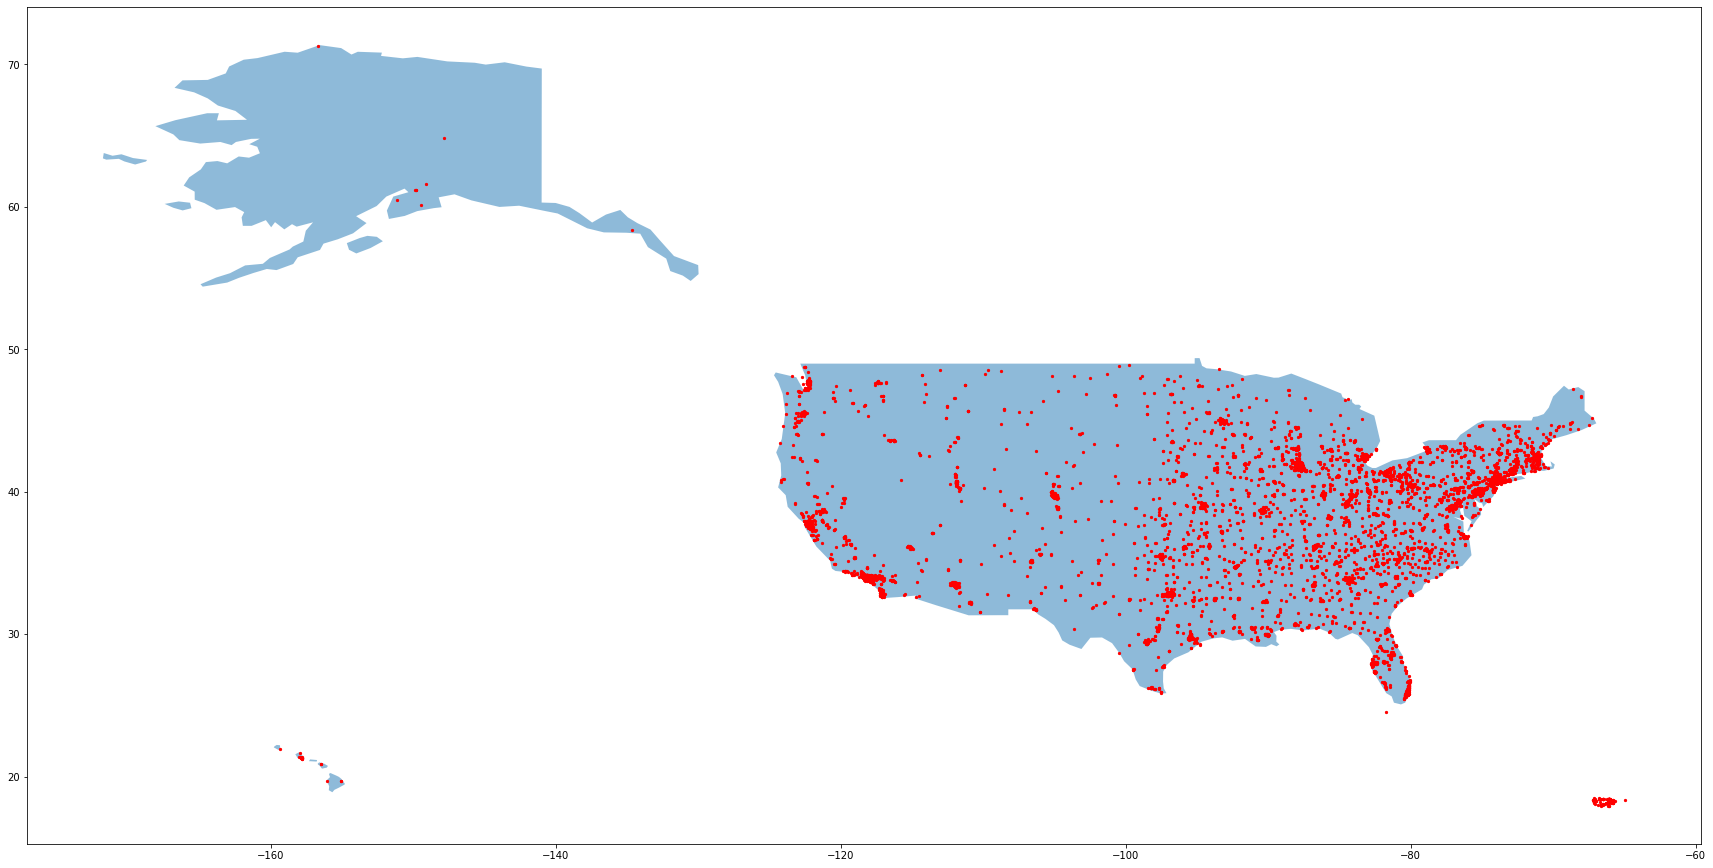

In [349]:
#show schools on us map to give idea of where most schools are
#use 2018_2019 dataset since it includes latitude and longitude
df_lat_long = pd.read_csv('Lat_Long_Data.csv',
                 usecols=["LATITUDE", "LONGITUDE"])
df_lat_long.dropna()
crs = {'init': 'epsg:4326'}
street_map = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
street_map = street_map[(street_map.iso_a3 == 'USA')]
base = street_map.plot(figsize=(30,30), alpha = 0.5)
geometry = [Point(xy) for xy in zip(df_lat_long["LONGITUDE"], df_lat_long["LATITUDE"])]
geo_df = gpd.GeoDataFrame(df_lat_long, crs=crs, geometry=geometry)
geo_df = geo_df[(geo_df["LONGITUDE"] < 0) & (geo_df["LATITUDE"] > 0)]
geo_df.plot(ax = base, markersize = 5, color='red', marker="o")

In [350]:
#create copy for what we need and remove Null and PrivarySuppressed
df = pd.DataFrame()
df["MD_EARN_WNE_P10"] = all_data_df["MD_EARN_WNE_P10"]
df["COSTT4_A"] = all_data_df["COSTT4_A"]
df["INSTNM"] = all_data_df["INSTNM"]
nan_value = float("NaN")
df.replace("PrivacySuppressed", nan_value, inplace=True)
df.dropna(inplace=True)
df["MD_EARN_WNE_P10"] = df["MD_EARN_WNE_P10"].astype(str).astype(int)


#show top cost schools
print("HIGHEST COST SCHOOLS:")
print(df.nlargest(10, columns=['COSTT4_A'])[['INSTNM', 'COSTT4_A']])
print()

#show top salary schools
print("HIGHEST SALARY SCHOOLS:")
print(df.nlargest(10, columns=['MD_EARN_WNE_P10'])[['INSTNM', 'MD_EARN_WNE_P10']])

HIGHEST COST SCHOOLS:
                                           INSTNM  COSTT4_A
2158            Washington University in St Louis   62594.0
1037                        University of Chicago   62425.0
2454  Columbia University in the City of New York   61540.0
2245                            Dartmouth College   61398.0
704                           Wesleyan University   61167.0
1138                      Northwestern University   60729.0
456                            Occidental College   60655.0
353                           Harvey Mudd College   60613.0
293                     Claremont McKenna College   60065.0
2581                          New York University   60059.0

HIGHEST SALARY SCHOOLS:
                                              INSTNM  MD_EARN_WNE_P10
2403  Albany College of Pharmacy and Health Sciences           122600
1736                                MCPHS University           112700
1738           Massachusetts Institute of Technology            94200
3416         

In [351]:
#show bottom cost schools
print("LOWEST COST SCHOOLS:")
print(df.nsmallest(10, columns=['COSTT4_A'])[['INSTNM', 'COSTT4_A']])
print()

#show bottom salary schools
print("LOWEST SALARY SCHOOLS:")
print(df.nsmallest(10, columns=['MD_EARN_WNE_P10'])[['INSTNM', 'MD_EARN_WNE_P10']])

LOWEST COST SCHOOLS:
                                                 INSTNM  COSTT4_A
2036                      Pearl River Community College    5285.0
7386                                 Augusta University    7715.0
988                      University of Hawaii-West Oahu    9874.0
3678              Southwest Tennessee Community College    9956.0
1004                     Brigham Young University-Idaho   10438.0
2748                    Elizabeth City State University   10620.0
3616                  Cleveland State Community College   10764.0
1557                 Southern University at New Orleans   10889.0
182   University of Arkansas Community College-Morri...   11593.0
3832          The University of Texas Rio Grande Valley   11601.0

LOWEST SALARY SCHOOLS:
                                     INSTNM  MD_EARN_WNE_P10
1070             Hebrew Theological College            21400
2772                    Livingstone College            21400
2029    Mississippi Valley State University   

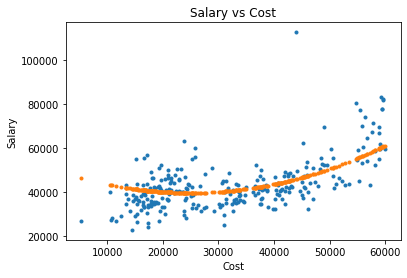

In [352]:
#Single Variable: Salary vs Cost
#create copy for what we need and remove Null and PrivarySuppressed
df = pd.DataFrame()
df["MD_EARN_WNE_P10"] = all_data_df["MD_EARN_WNE_P10"]
df["COSTT4_A"] = all_data_df["COSTT4_A"]
nan_value = float("NaN")
df.replace("PrivacySuppressed", nan_value, inplace=True)
df.dropna(inplace=True)
df["MD_EARN_WNE_P10"] = df["MD_EARN_WNE_P10"].astype(str).astype(int)

#Get proper predictor and target variables
X = df['COSTT4_A'].values.reshape(-1,1)
y = df['MD_EARN_WNE_P10'].values.reshape(-1,1)

#split into test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#use degree 2 since looked paroblic
poly = PolynomialFeatures(degree=2)
X_train_ = poly.fit_transform(X_train)
X_test_ = poly.fit_transform(X_test)

#fit model
regressor = linear_model.LinearRegression()
regressor.fit(X_train_, y_train)
y_pred = regressor.predict(X_test_)

#plot model
plt.title("Salary vs Cost")
plt.xlabel('Cost')
plt.ylabel('Salary')
plt.plot(X_test,y_test,'.')
plt.plot(X_test, y_pred, '.')

In [353]:
#Loss for Salary vs Cost
print("Salary vs Cost:")

#baseline
median_salary = np.median(y_test)
y_pred_median = [median_salary] * len(y_test)
print("Basline Mean Absolute Error:", metrics.mean_absolute_error(y_test, y_pred_median))

#actual
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))

Salary vs Cost:
Basline Mean Absolute Error: 7755.234657039711
Mean Absolute Error: 6365.925756612335


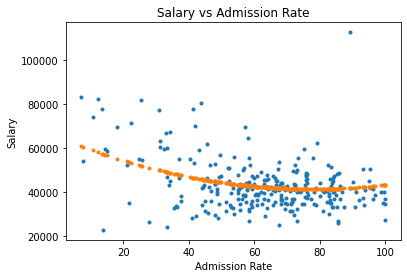

In [354]:
#Single Variable: Salary vs Admission Rate
#create copy for what we need and remove Null and PrivarySuppressed
df = pd.DataFrame()
df["MD_EARN_WNE_P10"] = all_data_df["MD_EARN_WNE_P10"]
df["ADM_RATE"] = all_data_df["ADM_RATE"]
nan_value = float("NaN")
df.replace("PrivacySuppressed", nan_value, inplace=True)
df.dropna(inplace=True)
df["MD_EARN_WNE_P10"] = df["MD_EARN_WNE_P10"].astype(str).astype(int)

#Get proper predictor and target variables
X = df['ADM_RATE'].values.reshape(-1,1)
y = df['MD_EARN_WNE_P10'].values.reshape(-1,1)



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#use degree 2 since looked slighly parabolic
poly = PolynomialFeatures(degree=2)
X_train_ = poly.fit_transform(X_train)
X_test_ = poly.fit_transform(X_test)

#fit model
regressor = linear_model.LinearRegression()
regressor.fit(X_train_, y_train)
y_pred = regressor.predict(X_test_)

#plot model
plt.title("Salary vs Admission Rate")
plt.xlabel('Admission Rate')
plt.ylabel('Salary')
plt.plot(X_test,y_test,'.')
plt.plot(X_test, y_pred, '.')

In [355]:
#Loss for Salary vs Admission Rate
print("Salary vs Admission Rate:")

#baseline
median_salary = np.median(y_test)
y_pred_median = [median_salary] * len(y_test)
print("Basline Mean Absolute Error:", metrics.mean_absolute_error(y_test, y_pred_median))

#actual
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))

Salary vs Admission Rate:
Basline Mean Absolute Error: 7755.234657039711
Mean Absolute Error: 7344.478027039874


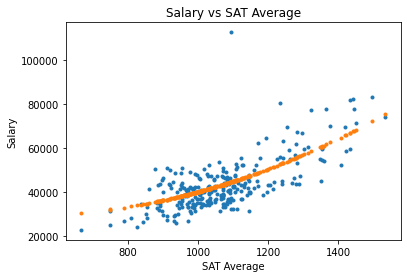

In [356]:
#Single Variable: Salary vs SAT Averate
#create copy for what we need and remove Null and PrivarySuppressed
df = pd.DataFrame()
df["MD_EARN_WNE_P10"] = all_data_df["MD_EARN_WNE_P10"]
df["SAT_AVG"] = all_data_df["SAT_AVG"]
nan_value = float("NaN")
df.replace("PrivacySuppressed", nan_value, inplace=True)
df.dropna(inplace=True)
df["MD_EARN_WNE_P10"] = df["MD_EARN_WNE_P10"].astype(str).astype(int)

#Get proper predictor and target variables
X = df['SAT_AVG'].values.reshape(-1,1)
y = df['MD_EARN_WNE_P10'].values.reshape(-1,1)

#split into test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#use degree 2 since looked slighly paraobolic
poly = PolynomialFeatures(degree=2)
X_train_ = poly.fit_transform(X_train)
X_test_ = poly.fit_transform(X_test)

#fit model
regressor = linear_model.LinearRegression()
regressor.fit(X_train_, y_train)
y_pred = regressor.predict(X_test_)

#plot model
plt.title("Salary vs SAT Average")
plt.xlabel('SAT Average')
plt.ylabel('Salary')
plt.plot(X_test,y_test,'.')
plt.plot(X_test, y_pred, '.')

In [357]:
#Loss for Salary vs SAT Average
print("Salary vs SAT Average:")

#baseline
median_salary = np.median(y_test)
y_pred_median = [median_salary] * len(y_test)
print("Basline Mean Absolute Error:", metrics.mean_absolute_error(y_test, y_pred_median))

#actual
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))

Salary vs SAT Average:
Basline Mean Absolute Error: 7755.234657039711
Mean Absolute Error: 5933.729039049092


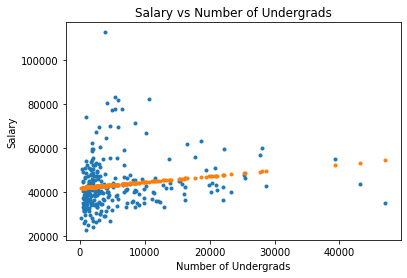

In [358]:
#Single Variable: Salary vs Number of Undergrads
#create copy for what we need and remove Null and PrivarySuppressed
df = pd.DataFrame()
df["MD_EARN_WNE_P10"] = all_data_df["MD_EARN_WNE_P10"]
df["UGDS"] = all_data_df["UGDS"]
nan_value = float("NaN")
df.replace("PrivacySuppressed", nan_value, inplace=True)
df.dropna(inplace=True)
df["MD_EARN_WNE_P10"] = df["MD_EARN_WNE_P10"].astype(str).astype(int)

#Get proper predictor and target variables
X = df['UGDS'].values.reshape(-1,1)
y = df['MD_EARN_WNE_P10'].values.reshape(-1,1)

#split into test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#use degree 1
poly = PolynomialFeatures(degree=1)
X_train_ = poly.fit_transform(X_train)
X_test_ = poly.fit_transform(X_test)

#fit model
regressor = linear_model.LinearRegression()
regressor.fit(X_train_, y_train)
y_pred = regressor.predict(X_test_)

#plot model
plt.title("Salary vs Number of Undergrads")
plt.xlabel('Number of Undergrads')
plt.ylabel('Salary')
plt.plot(X_test,y_test,'.')
plt.plot(X_test, y_pred, '.')

In [359]:
#Loss for Salary vs Number of Undergrads
print("Salary vs Number of Undergrads:")

#baseline
median_salary = np.median(y_test)
y_pred_median = [median_salary] * len(y_test)
print("Basline Mean Absolute Error:", metrics.mean_absolute_error(y_test, y_pred_median))

#actual
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))

Salary vs Number of Undergrads:
Basline Mean Absolute Error: 7755.234657039711
Mean Absolute Error: 7979.579607513111


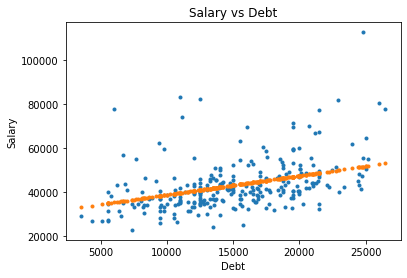

In [360]:
#Single Variable: Salary vs SAT Averate
#create copy for what we need and remove Null and PrivarySuppressed
df = pd.DataFrame()
df["MD_EARN_WNE_P10"] = all_data_df["MD_EARN_WNE_P10"]
df["DEBT_MDN"] = all_data_df["DEBT_MDN"]
nan_value = float("NaN")
df.replace("PrivacySuppressed", nan_value, inplace=True)
df.dropna(inplace=True)
df["MD_EARN_WNE_P10"] = df["MD_EARN_WNE_P10"].astype(str).astype(int)
df["DEBT_MDN"] = df["DEBT_MDN"].astype(str).astype(float)

#Get proper predictor and target variables
X = df['DEBT_MDN'].values.reshape(-1,1)
y = df['MD_EARN_WNE_P10'].values.reshape(-1,1)

#split into test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#use degree 1 since looked linear
poly = PolynomialFeatures(degree=1)
X_train_ = poly.fit_transform(X_train)
X_test_ = poly.fit_transform(X_test)

#fit model
regressor = linear_model.LinearRegression()
regressor.fit(X_train_, y_train)
y_pred = regressor.predict(X_test_)

#plot model
plt.title("Salary vs Debt")
plt.xlabel('Debt')
plt.ylabel('Salary')
plt.plot(X_test,y_test,'.')
plt.plot(X_test, y_pred, '.')

In [361]:
#Loss for Salary vs Debt
print("Salary vs Debt:")

#baseline
median_salary = np.median(y_test)
y_pred_median = [median_salary] * len(y_test)
print("Basline Mean Absolute Error:", metrics.mean_absolute_error(y_test, y_pred_median))

#actual
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))

Salary vs Debt:
Basline Mean Absolute Error: 7755.234657039711
Mean Absolute Error: 7023.833666754997


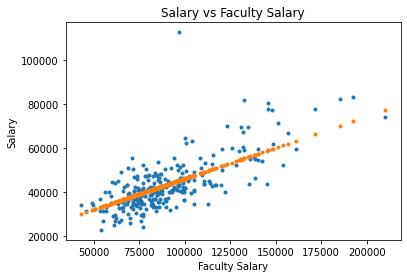

In [362]:
#Single Variable: Salary vs Average Faculty Salary
#create copy for what we need and remove Null and PrivarySuppressed
df = pd.DataFrame()
df["MD_EARN_WNE_P10"] = all_data_df["MD_EARN_WNE_P10"]
df["AVGFACSAL"] = all_data_df["AVGFACSAL"]
nan_value = float("NaN")
df.replace("PrivacySuppressed", nan_value, inplace=True)
df.dropna(inplace=True)
df["MD_EARN_WNE_P10"] = df["MD_EARN_WNE_P10"].astype(str).astype(int)

#Get proper predictor and target variables
X = df['AVGFACSAL'].values.reshape(-1,1)
y = df['MD_EARN_WNE_P10'].values.reshape(-1,1)

#split into test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#use degree 1 since looked linear
poly = PolynomialFeatures(degree=1)
X_train_ = poly.fit_transform(X_train)
X_test_ = poly.fit_transform(X_test)

#fit model
regressor = linear_model.LinearRegression()
regressor.fit(X_train_, y_train)
y_pred = regressor.predict(X_test_)

#plot model
plt.title("Salary vs Faculty Salary")
plt.xlabel('Faculty Salary')
plt.ylabel('Salary')
plt.plot(X_test,y_test,'.')
plt.plot(X_test, y_pred, '.')

In [363]:
#Loss for Salary vs Factuly Salary
print("Salary vs Faculty Salary:")

#baseline
median_salary = np.median(y_test)
y_pred_median = [median_salary] * len(y_test)
print("Basline Mean Absolute Error:", metrics.mean_absolute_error(y_test, y_pred_median))

#actual
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))

Salary vs Faculty Salary:
Basline Mean Absolute Error: 7755.234657039711
Mean Absolute Error: 5466.997805978946


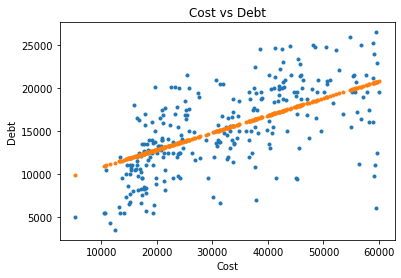

In [364]:
#Single Variable: Cost of Attendance vs Debt 
#Used to check if two variables are related
#create copy for what we need and remove Null and PrivarySuppressed
df = pd.DataFrame()
df["DEBT_MDN"] = all_data_df["DEBT_MDN"]
df["COSTT4_A"] = all_data_df["COSTT4_A"]
nan_value = float("NaN")
df.replace("PrivacySuppressed", nan_value, inplace=True)
df.dropna(inplace=True)
df["DEBT_MDN"] = df["DEBT_MDN"].astype(str).astype(float)

#Get proper predictor and target variables
X = df['COSTT4_A'].values.reshape(-1,1)
y = df['DEBT_MDN'].values.reshape(-1,1)

#split into test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#use degree 1 since looked linear
poly = PolynomialFeatures(degree=1)
X_train_ = poly.fit_transform(X_train)
X_test_ = poly.fit_transform(X_test)

#fit model
regressor = linear_model.LinearRegression()
regressor.fit(X_train_, y_train)
y_pred = regressor.predict(X_test_)

#plot model
plt.title("Cost vs Debt")
plt.xlabel('Cost')
plt.ylabel('Debt')
plt.plot(X_test,y_test,'.')
plt.plot(X_test, y_pred, '.')

In [365]:
#Loss for Debt vs Cost
print("Debt vs Cost:")

#baseline
median_debt = np.median(y_test)
y_pred_median = [median_debt] * len(y_test)
print("Basline Mean Absolute Error:", metrics.mean_absolute_error(y_test, y_pred_median))

#actual
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))

Debt vs Cost:
Basline Mean Absolute Error: 4069.2906137184114
Mean Absolute Error: 2974.741562482022


In [366]:
#MULTIVARIABLE
df = pd.DataFrame()
df["COSTT4_A_BY_THOUSAND"] = all_data_df["COSTT4_A"]/1000
df["COSTT4_A_BY_THOUSAND_SQUARED"] = df_with_state["COSTT4_A_BY_THOUSAND"]**2
df["ADM_RATE"] = all_data_df["ADM_RATE"]
df["ADM_RATE_SQUARED"] = all_data_df["ADM_RATE"] ** 2
df["SAT_AVG"] = all_data_df["SAT_AVG"]
df["SAT_AVG_SQUARED"] = all_data_df["SAT_AVG"] ** 2
df["AVGFACSAL"] = all_data_df["AVGFACSAL"]

X = df.values
y = all_data_df['MD_EARN_WNE_P10'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)
regressor = linear_model.LinearRegression()
regressor.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [367]:
#Actual vs Prediction
y_pred = regressor.predict(X_test)
df_res = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_actual_pred = df_res.head(10)
df_actual_pred

,Actual,Predicted
0,36900,41432.333311
1,81800,62114.049597
2,25900,34796.675303
3,35800,41348.933690
4,64800,50843.588581
5,83200,74673.859324
6,42500,42428.907051
7,32800,35842.059739
8,41000,43725.573370
9,36600,37472.763144


In [368]:
#Loss for Salary vs Multivariable
print("Salary vs Multivariable:")

#baseline
y_test = y_test.astype(np.float)
median_salary = np.median(y_test)
y_pred_median = [median_salary] * len(y_test)
print("Baseline Mean Absolute Error:", metrics.mean_absolute_error(y_test, y_pred_median))

#actual
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))

Salary vs Multivariable:
Baseline Mean Absolute Error: 7755.234657039711
Mean Absolute Error: 4824.1636070368695


In [369]:
#Add Location to out Multivariable Regression
df_with_state = pd.get_dummies(all_data_df, prefix_sep="__",
                             columns=["STABBR"])
label_encoders = {}
new_le = LabelEncoder()
df_with_state["STABBR"] = new_le.fit_transform(all_data_df["STABBR"])
label_encoders["STABBR"] = new_le 

df_with_state["COSTT4_A_BY_THOUSAND"] = df_with_state["COSTT4_A"]/1000
df_with_state["COSTT4_A_BY_THOUSAND_SQUARED"] = df_with_state["COSTT4_A_BY_THOUSAND"]**2
df_with_state["ADM_RATE_SQUARED"] = all_data_df["ADM_RATE"] ** 2
df_with_state["SAT_AVG_SQUARED"] = all_data_df["SAT_AVG"] ** 2
df_with_state = df_with_state.drop(["INSTNM", "UGDS", "DEBT_MDN", "STABBR", "COSTT4_A", "MD_EARN_WNE_P10"], axis=1)

#actual regression
X = df_with_state.values
y = all_data_df['MD_EARN_WNE_P10'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)
regressor = linear_model.LinearRegression()
regressor.fit(X_train,y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [370]:
#Actual vs Prediction
y_pred = regressor.predict(X_test)
df_res = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_actual_pred = df_res.head(10)
df_actual_pred

,Actual,Predicted
0,36900,43327.002037
1,81800,65044.695756
2,25900,42381.479160
3,35800,37621.127713
4,64800,54053.766002
5,83200,75638.555545
6,42500,40039.906782
7,32800,35586.081657
8,41000,43696.410803
9,36600,38848.323110


In [371]:
#Loss for Salary vs Multivariable with States
print("Salary vs Multivariable with States:")

#baseline
y_test = y_test.astype(np.float)
median_salary = np.median(y_test)
y_pred_median = [median_salary] * len(y_test)
print("Baseline Mean Absolute Error:", metrics.mean_absolute_error(y_test, y_pred_median))

#actual
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))

Salary vs Multivariable with States:
Baseline Mean Absolute Error: 7755.234657039711
Mean Absolute Error: 4444.555004617172
